# Why Siamese?

**Siamese networks are ideal for signature verification because:**

1. **Verification Focus:** They are designed to compare pairs of inputs and assess their similarity, making them perfect for determining if two signatures are from the same person or not.
2. **Learning Embeddings:** They generate feature embeddings for signatures, which capture key patterns and allow for effective comparison, even with variations in signature style.
3. **One-Shot Learning:** Siamese networks excel in scenarios with limited data, making them suitable for signature verification with only one example per person.
4. **Efficient and Scalable:** They can handle large databases by comparing pairs of embeddings, reducing the need for retraining or individual classifiers for each signature.
5. **Flexibility:** They handle variations in signatures due to different writing styles, noise, or conditions, ensuring robust performance.

# Importing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from keras import applications
from keras import layers
from keras import losses
from keras import ops
from keras import optimizers
from keras import metrics
from keras import Model
from keras.applications import resnet
from collections import defaultdict
import re
from tensorflow.keras.applications import ResNet50
from keras.applications import resnet
from PIL import Image
from sklearn.model_selection import train_test_split
import keras

In [2]:
epochs = 10
batch_size = 16
margin = 1  # Margin for contrastive loss.

# Reading

In [3]:
base_path = '/kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset'

# Initialize dictionaries to hold the paths of real and forged signatures
real_signatures = {}
forge_signatures = {}

# Define the target size for resizing
target_size = (224, 224)

# Process image paths into arrays
def process_image(image_path, target_size=(224, 224)):
    """Load and preprocess an image."""
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = image.resize(target_size)  # Resize to target dimensions
    return np.array(image) / 255.0  # Normalize pixel values to [0, 1]

# Function to load real and forged signatures from directories
def load_signatures():
    for dataset in ['dataset1', 'dataset2', 'dataset3', 'dataset4']:
        real_path = os.path.join(base_path, dataset, 'real')
        forge_path = os.path.join(base_path, dataset, 'forge')

        # Load real signatures
        if os.path.exists(real_path):
            for filename in os.listdir(real_path):
                match = re.match(r'(\d{3})(\d{5})\.png', filename)
                if match:
                    person_id = match.group(1)
                    if person_id not in real_signatures:
                        real_signatures[person_id] = []
                    real_signatures[person_id].append(os.path.join(real_path, filename))

        # Load forged signatures
        if os.path.exists(forge_path):
            for filename in os.listdir(forge_path):
                match = re.match(r'(\d{3})(\d{5})\.png', filename)
                if match:
                    person_id = match.group(1)
                    if person_id not in forge_signatures:
                        forge_signatures[person_id] = []
                    forge_signatures[person_id].append(os.path.join(forge_path, filename))

# Load signatures
load_signatures()

# Create pairs

Train size: 159
Validation size: 53
Test size: 54
Training Set Pairs:


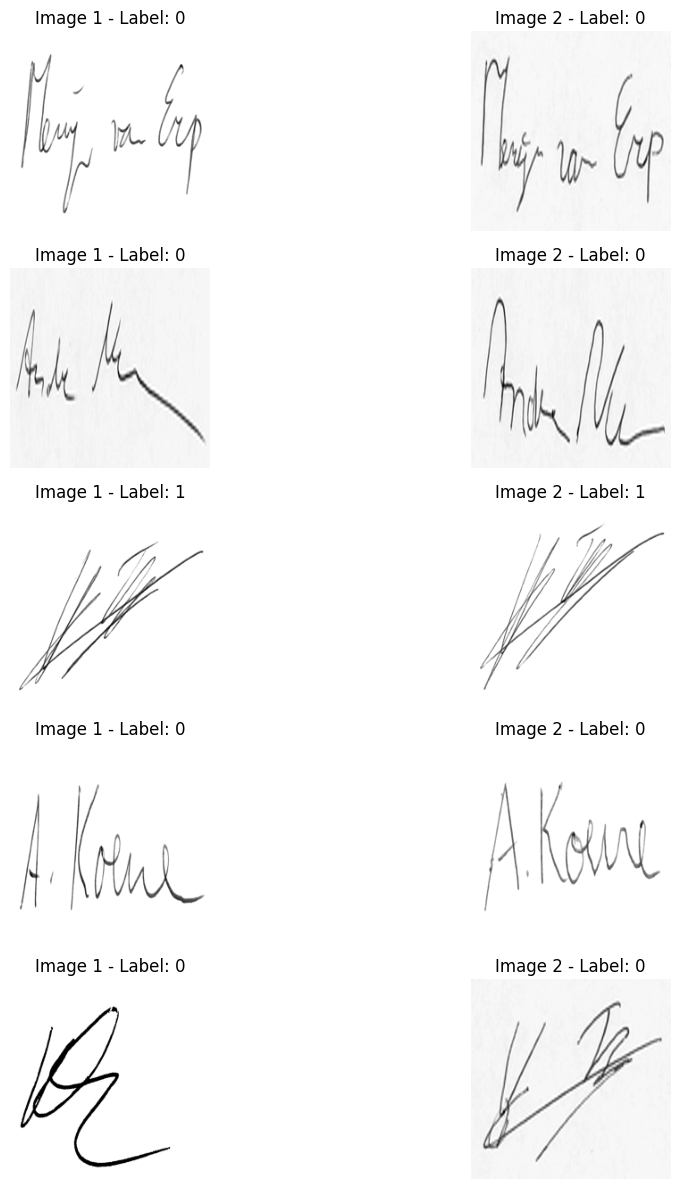

Validation Set Pairs:


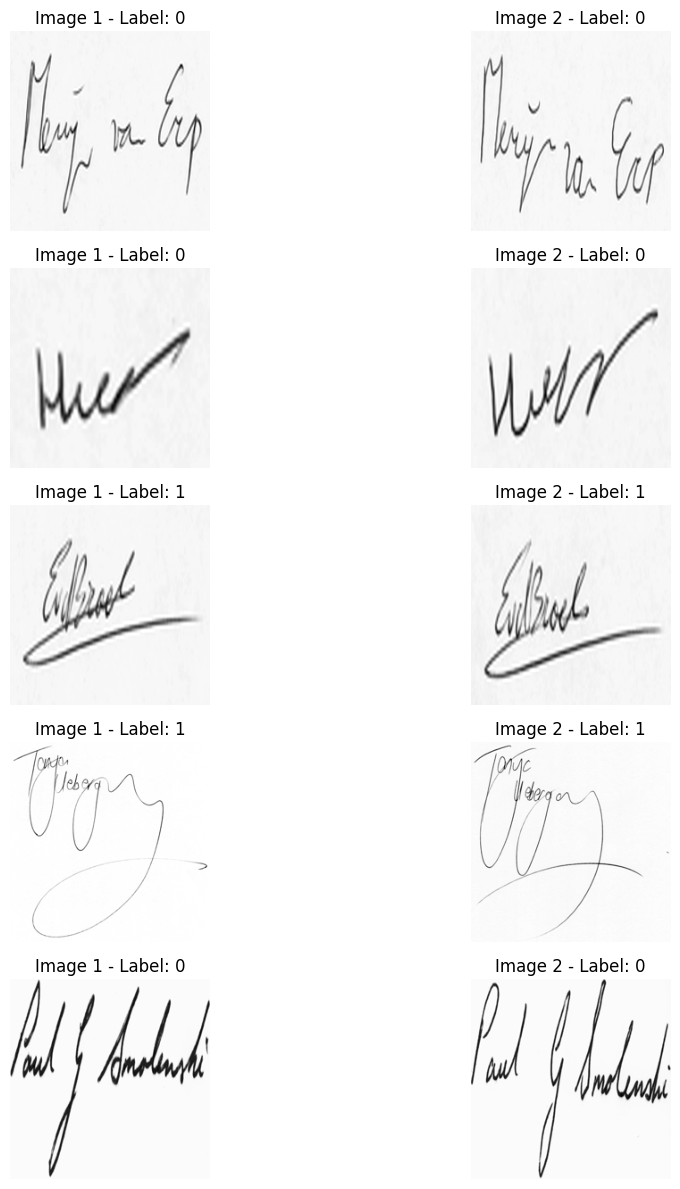

Test Set Pairs:


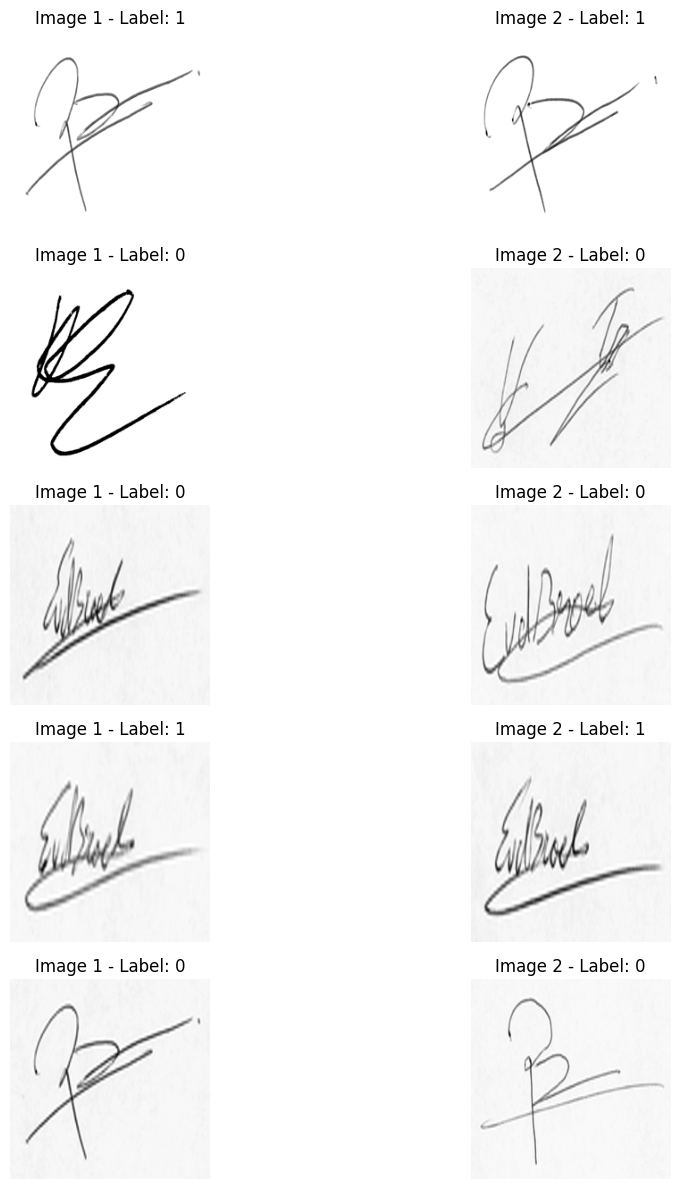

In [4]:
pairs = []
labels = []

for person_id in real_signatures:
    if person_id in forge_signatures:
        real_images = real_signatures[person_id]
        suffix_to_negatives = defaultdict(list)

        for other_person_id, forge_images in forge_signatures.items():
            if other_person_id != person_id:
                for forge_image in forge_images:
                    match = re.match(r'\d{3}(\d{5})\.png', os.path.basename(forge_image))
                    if match:
                        suffix_to_negatives[match.group(1)].append(process_image(forge_image))

        # Create Positive Pairs (Label 1)
        for i in range(len(real_images) - 1):
            anchor = process_image(real_images[i])
            positive = process_image(real_images[i + 1])
            pairs.append((anchor, positive))
            labels.append(1)

        # SCreate Negative Pairs (Label 0)
        for anchor_path in real_images:
            anchor = process_image(anchor_path)
            match = re.match(r'\d{3}(\d{5})\.png', os.path.basename(anchor_path))
            if match:
                suffix = match.group(1)
                if suffix in suffix_to_negatives:
                    # Pick the first matching negative
                    negative = suffix_to_negatives[suffix][0]
                    pairs.append((anchor, negative))
                    labels.append(0)
                else:
                    print(f"No matching negative found for Anchor: {anchor_path} with suffix: {suffix}")

pairs = np.array(pairs)
labels = np.array(labels)

# Step 2: Split into train, validation, and test sets
pairs_train, pairs_temp, labels_train, labels_temp = train_test_split(pairs, labels, test_size=0.4, random_state=42)
pairs_val, pairs_test, labels_val, labels_test = train_test_split(pairs_temp, labels_temp, test_size=0.5, random_state=42)

# Check the sizes of the splits
print(f"Train size: {len(pairs_train)}")
print(f"Validation size: {len(pairs_val)}")
print(f"Test size: {len(pairs_test)}")

# Function to plot preprocessed image pairs
def plot_preprocessed_pairs(pairs, labels, num_pairs=5):
    plt.figure(figsize=(12, 12))

    for i in range(min(num_pairs, len(pairs))):
        img1, img2 = pairs[i]
        label = labels[i]
        
        plt.subplot(num_pairs, 2, 2*i+1)
        plt.imshow(img1, cmap='gray')
        plt.title(f"Image 1 - Label: {label}")
        plt.axis('off')

        plt.subplot(num_pairs, 2, 2*i+2)
        plt.imshow(img2, cmap='gray')
        plt.title(f"Image 2 - Label: {label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Plot a few examples from the train, validation, and test sets
print("Training Set Pairs:")
plot_preprocessed_pairs(pairs_train, labels_train, num_pairs=5)

print("Validation Set Pairs:")
plot_preprocessed_pairs(pairs_val, labels_val, num_pairs=5)

print("Test Set Pairs:")
plot_preprocessed_pairs(pairs_test, labels_test, num_pairs=5)

# Helper functions

In [5]:
def augment_image(image):
    """
    Apply random data augmentation transformations to an image.
    """
    # Add a channel dimension if missing
    image = tf.expand_dims(image, axis=-1)  # Shape becomes (224, 224, 1)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image

In [6]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = ops.sum(ops.square(x - y), axis=1, keepdims=True)
    return ops.sqrt(ops.maximum(sum_square, keras.backend.epsilon()))

In [7]:
def loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = ops.square(y_pred)
        margin_square = ops.square(ops.maximum(margin - (y_pred), 0))
        return ops.mean((1 - y_true) * square_pred + (y_true) * margin_square)

    return contrastive_loss

In [8]:
pairs_train = np.expand_dims(pairs_train, axis=-1)
pairs_val = np.expand_dims(pairs_val, axis=-1)
pairs_test = np.expand_dims(pairs_test, axis=-1)

In [9]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]

x_val_1 = pairs_val[:, 0]  # x_val_1.shape = (60000, 28, 28)
x_val_2 = pairs_val[:, 1]

x_test_1 = pairs_test[:, 0]  # x_test_1.shape = (20000, 28, 28)
x_test_2 = pairs_test[:, 1]

In [10]:
input = keras.layers.Input((224, 224, 1))
x = keras.layers.Conv2D(16, (5, 5), activation="relu", padding="same")(input)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation="relu")(x)

embedding_network = keras.Model(input, x, name="embedding_network")
input_1 = keras.layers.Input((224, 224, 1))
input_2 = keras.layers.Input((224, 224, 1))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))([tower_1, tower_2])
output_layer = keras.layers.Dense(1, activation="sigmoid")(merge_layer)

siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [11]:
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_network   │ (None, 128)       │ 12,850,240 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ embedding_networ… │
│                     │                   │            │ embedding_networ… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          2 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,850,242 (49.02 MB)

 Trainable params: 12,850,242 (49.02 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=100,
)

Epoch 1/100


I0000 00:00:1734333346.802341      87 service.cc:145] XLA service 0x7c4eac004f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734333346.802418      87 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5876 - loss: 0.2448

I0000 00:00:1734333349.868612      87 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 304ms/step - accuracy: 0.5780 - loss: 0.2452 - val_accuracy: 0.4906 - val_loss: 0.2514
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5267 - loss: 0.2280 - val_accuracy: 0.4906 - val_loss: 0.2452
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5763 - loss: 0.1989 - val_accuracy: 0.4906 - val_loss: 0.2581
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5097 - loss: 0.2107 - val_accuracy: 0.4906 - val_loss: 0.2579
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4650 - loss: 0.2100 - val_accuracy: 0.4906 - val_loss: 0.2636
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5419 - loss: 0.1865 - val_accuracy: 0.4906 - val_loss: 0.2542
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4805 - loss: 0.1824 - val_accuracy: 0.4906 - val_loss: 0.2574
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5951 - loss: 0.1493 - val_accuracy: 0.4906 - val_

# Testing

In [13]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step - accuracy: 0.8576 - loss: 0.1201
test loss, test acc: [0.1245834156870842, 0.8333333134651184]


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

predictions = siamese.predict([x_test_1, x_test_2])
predicted_labels = (predictions > 0.5).astype("int32")

print("\nClassification Report:")
print(classification_report(labels_test, predicted_labels))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.97      0.86        29
           1       0.94      0.68      0.79        25

    accuracy                           0.83        54
   macro avg       0.86      0.82      0.83        54
weighted avg       0.85      0.83      0.83        54




Confusion Matrix:


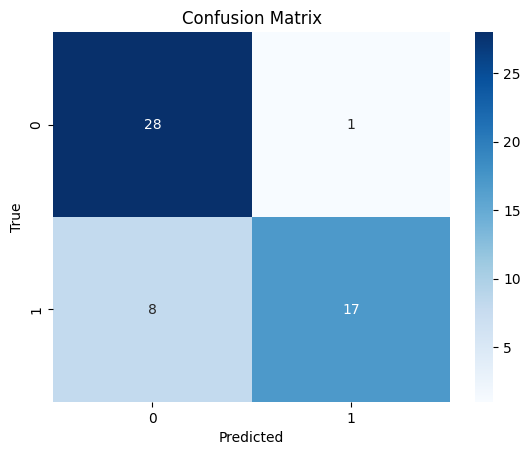

In [18]:
print("\nConfusion Matrix:")
cm = confusion_matrix(labels_test, predicted_labels)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


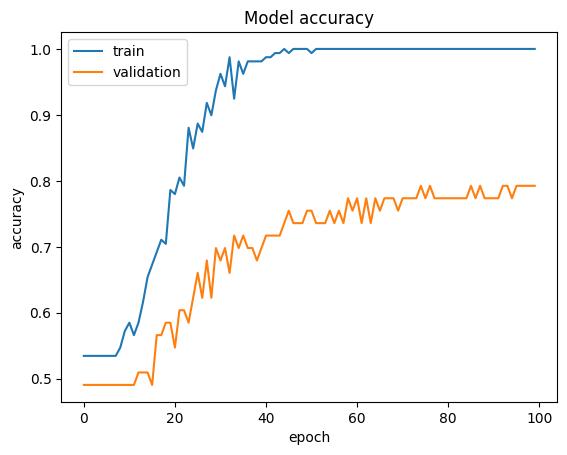

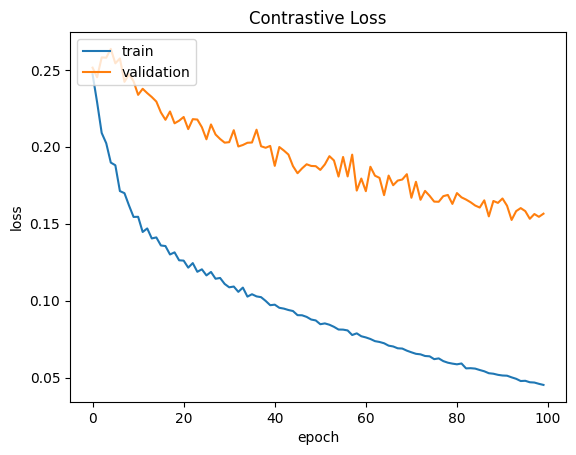

In [14]:
def plt_metric(history, metric, title, has_valid=True):

    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")